In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import  load_img
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define image size and other parameters
img_width, img_height = 256, 256
batchsize = 32
epochs = 4
num_of_class = 2

train = keras. utils.image_dataset_from_directory(
    directory=r"D:\Project\Chest X-Ray Images(Pneumonia)\chest_xray\train",
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

validation = keras. utils.image_dataset_from_directory(
    directory=r"D:\Project\Chest X-Ray Images(Pneumonia)\chest_xray\val",
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras. utils.image_dataset_from_directory(
    directory=r"D:\Project\Chest X-Ray Images(Pneumonia)\chest_xray\test",
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


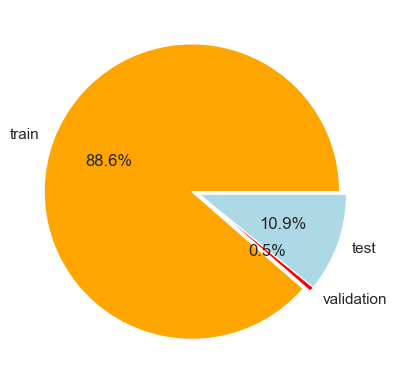

In [3]:
plt.pie([len(train), len(validation), len(test)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['orange', 'red', 'lightblue'], explode=(0.05, 0, 0))
plt.show()

In [4]:
print(train.class_names)
print(validation.class_names)
print(test.class_names)

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


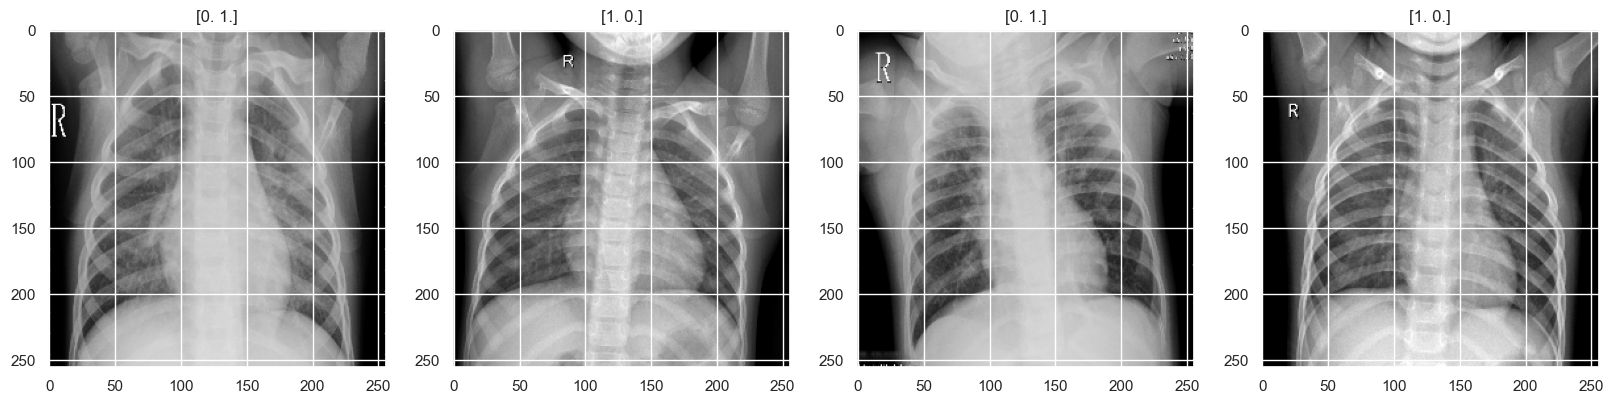

In [5]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
# Extracting Features and Labels
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature.numpy())
    y_train.append(label.numpy())

for feature, label in test:
    x_test.append(feature.numpy())
    y_test.append(label.numpy())
    
for feature, label in validation:
    x_val.append(feature.numpy())
    y_val.append(label.numpy())

# Concatenate the lists to get the full 'x' and 'y' arrays
x_train = np.concatenate(x_train, axis=0)
x_val = np.concatenate(x_val, axis=0)
x_test = np.concatenate(x_test, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_val = np.concatenate(y_val, axis=0)
y_test = np.concatenate(y_test, axis=0)


In [7]:
# check the shapes of 'x_train' and 'y_train':
print("Shape of 'x_train':", x_train.shape)
print("Shape of 'y_train':", y_train.shape)
print("Shape of 'x_val':", x_val.shape)
print("Shape of 'y_val':", y_val.shape)
print("Shape of 'x_test':", x_test.shape)
print("Shape of 'y_test':", y_test.shape)

Shape of 'x_train': (5216, 256, 256, 3)
Shape of 'y_train': (5216, 2)
Shape of 'x_val': (16, 256, 256, 3)
Shape of 'y_val': (16, 2)
Shape of 'x_test': (624, 256, 256, 3)
Shape of 'y_test': (624, 2)


In [8]:
# Pixel Value Scaling for Datasets: Normalizing and Standardizing the Data
x_train=x_train/256
x_val=x_val/256
x_test=x_test/256

In [9]:
#we use transfer learning with VGG16 as the base model
def CNN_Model():
    base_model = VGG16(weights='imagenet', include_top = False, input_shape=(img_width, img_height, 3))
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    for i in range(3):
        base_model.layers[-2-i].trainable = True

    CNN = Sequential()
    CNN.add(Input(shape=(img_width, img_height,3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dropout(0.3))
    CNN.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(2, activation='sigmoid'))
    
    return CNN

# Training The CNN
model = CNN_Model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()  
# Visualized Layers of CNN
keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,909,378 (72.13 MB)

 Trainable params: 11,274,114 (43.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [10]:
hist = model.fit(x_train, y_train, epochs= 6, validation_data= (x_val, y_val))
print(hist.history)
best_score = max(hist.history['val_accuracy'])
print(f"Best Validation score is: {best_score}")

Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 2517s 15s/step - accuracy: 0.7855 - loss: 1.0476 - val_accuracy: 0.5000 - val_loss: 4.0187
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 1435s 9s/step - accuracy: 0.9473 - loss: 0.2663 - val_accuracy: 0.6250 - val_loss: 2.1719
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 1667s 10s/step - accuracy: 0.9720 - loss: 0.1691 - val_accuracy: 0.9375 - val_loss: 0.3559
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 1685s 10s/step - accuracy: 0.9841 - loss: 0.0869 - val_accuracy: 1.0000 - val_loss: 0.0515
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 1456s 9s/step - accuracy: 0.9852 - loss: 0.0746 - val_accuracy: 0.9375 - val_loss: 0.1272
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 1491s 9s/step - accuracy: 0.9858 - loss: 0.0737 - val_accuracy: 0.9375 - val_loss: 0.1088
{'accuracy': [0.785467803478241, 0.9472776055335999, 0.9720091819763184, 0.9840874075889587, 0.985237717628479, 0.9858129024505615], 'loss': [1.0476220846176147, 0.266293466091156, 0.16911821067333221, 0.0868823453783989, 0

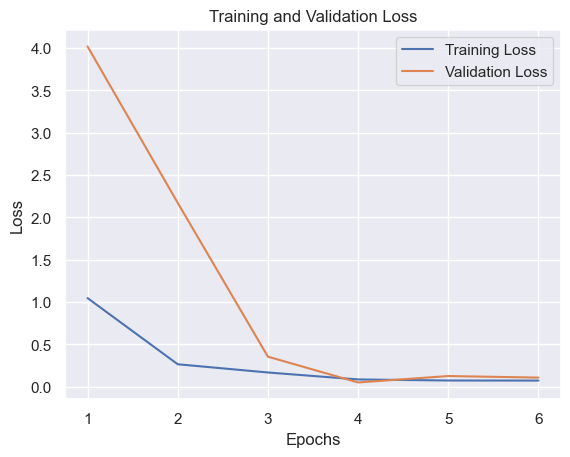

In [11]:
# Extract the training and validation loss values from the history object
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plot the loss graph
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

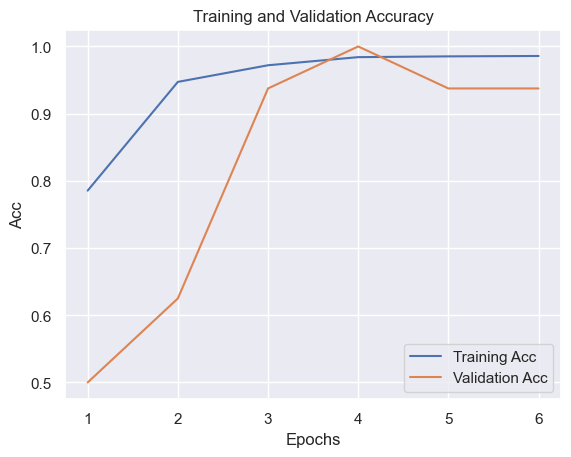

In [12]:
# Extract the training and validation loss values from the history object
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_accuracy) + 1)

# Plot the loss graph
plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Save the model
model.save('CNN_model.h5')
print ("Model saved successfully!")

Model saved successfully!
